# Extracting Tregs from a HTAN scRNAseq dataset.

## 1. Set up libraries

In [1]:
# If using google colab include the following install; otherwise skip if you have scanpy installed:
!pip install scanpy
!pip install celltypist

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.7/141.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 13.1 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=af9b56da368da656a21ddc4b9823b4058e11e87186b3cf09fd4eb3deb8391450
  Stored in directory: /home/jovyan/.cache/pip/wheels/4e/56/35/a748fc57279a4b84d0b332879445fed1ad8478e7257986b015
Successfully built session-info
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 81.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
from scipy.sparse import csr_matrix
import celltypist
from celltypist import models
import os

/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/opt

## 2. QC

In [3]:
## Define input output file paths
dir='/sbgenomics/project-files/'
file_name="VUMC_HTAN_VAL_DIS_NONEPI_V2"
input_path= os.path.join(dir, f"{file_name}.h5ad")
out_tregs_path = os.path.join(dir, f"{file_name}_tregs_v2.h5ad")


In [4]:
# load input data
adata= sc.read_h5ad(input_path)

In [5]:
adata

AnnData object with n_obs × n_vars = 10696 × 30234
    obs: 'HTAN Parent Data File ID', 'HTAN Specimen ID', 'Cell_Type', 'Tumor_Type', 'Sample_Classification'
    obsm: 'X_pca', 'X_umap'

In [6]:
# compute fraction of mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['mito_frac'] = adata.obs['pct_counts_mt'] / 100
print(adata.obs[['mito_frac']].head())

                       mito_frac
ACGGAATTTGCTCTAGT-0     0.655205
GAATGGGCACGTACCTTG-0    0.523529
TGACGTATCGGTGACGGAC-0   0.174750
ATCTAGCAGCGTGGATA-0     0.476034
GACGTCAGCAACGGTAGC-0    0.282565


count    10696.000000
mean         0.198230
std          0.129312
min          0.007299
25%          0.090087
50%          0.164309
75%          0.287160
max          0.679015
Name: mito_frac, dtype: float64

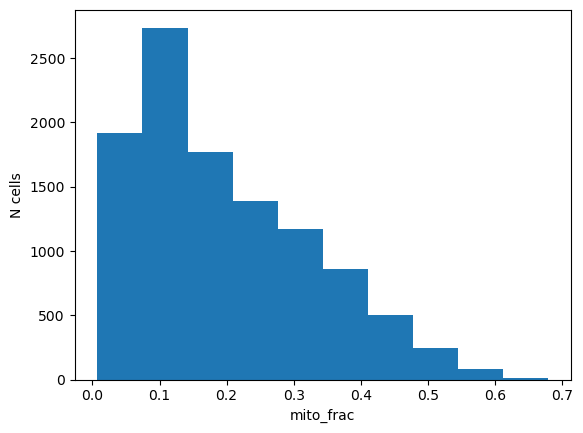

In [7]:
# Filtering and QC
plt.hist(adata.obs['mito_frac'])
plt.xlabel('mito_frac')
plt.ylabel('N cells')
pd.DataFrame.describe(adata.obs['mito_frac'])

We can see from this data that the authors already filtered cells with mito_frac > 20% (as mentioned in the manuscript).



count    10696.000000
mean      3283.134521
std       3262.034424
min        165.000000
25%       1172.000000
50%       2227.000000
75%       4275.000000
max      42273.000000
Name: total_counts, dtype: float64

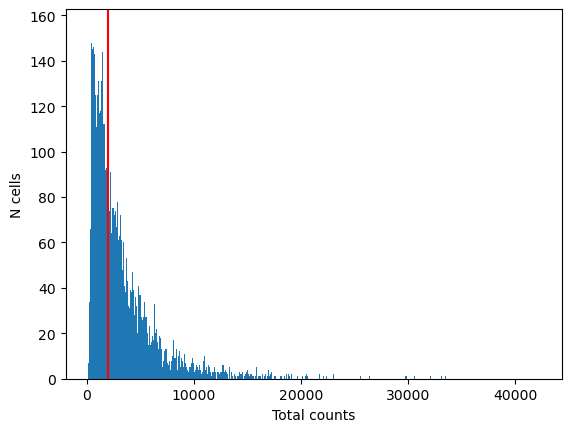

In [8]:
#plot histogram of number of counts per cell
plt.hist(adata.obs['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('N cells')
plt.axvline(2000, color='red')
#plt.xlim(0,1e3) just to take a look if there was filtering around 0 counts per cell
pd.DataFrame.describe(adata.obs['total_counts'])


From the plot and the statistics, we can infer that cell filtering, where true cells are distinguished from empty droplets based on the cumulative distribution of total molecule count, used a threshold of 100 for total counts.

count    10696.000000
mean      1178.816567
std        732.884396
min        141.000000
25%        657.000000
50%       1016.000000
75%       1527.250000
max       7170.000000
Name: n_genes_by_counts, dtype: float64

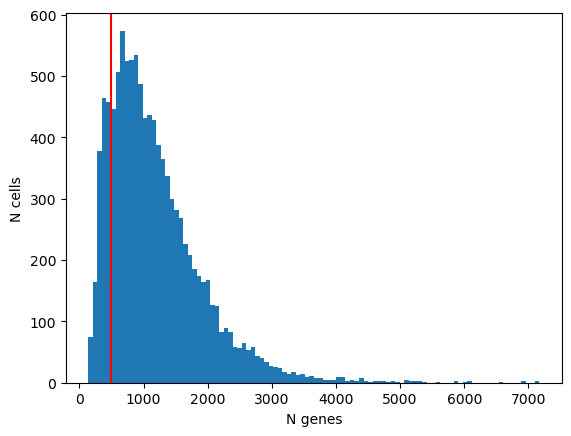

In [9]:
#plot histogram of number of unique genes by cells
plt.hist(adata.obs['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.axvline(500, color='red')
#plt.xlim(0,4e3)
pd.DataFrame.describe(adata.obs['n_genes_by_counts'])

From the plot and the statistics, we can infer that cells with low library complexity are filtered (cells that express very few unique genes) using a threshold of 70 for number of genes expressed by a cell.

So, it appears that we already have a file with data that went through pre-processing. No further filtering will be made to the original file.

## 3. Filtering

In [25]:
min_genes = 500
min_cells = 3
min_counts = 20
mt_threshold=0.2

In [ ]:
sc.pp.calculate_qc_metrics(adata_object)

In [ ]:
sc.pp.filter_cells(adata_object, min_genes = min_genes)

In [ ]:
sc.pp.filter_genes(adata_object, min_cells = min_cells)

In [ ]:
sc.pp.filter_genes(adata_object, min_counts = min_counts)

In [ ]:
# filter out high MT cells
adata_filtered = adata[adata.obs['mito_frac'] <= mito_threshold].copy()

## 3. Data Normalization and Log-transformation

Now that filtering has been assessed, the next step before using the CellTypist library is normalization. In order to call cells, the expression matrix must be pre-processed (and is required) as log1p normalised expression to 10,000 counts per cell.

So, we call the following functions:

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

We also run PCA and UMAP from the scanpy library for visualization:

In [11]:
sc.tl.pca(adata, svd_solver='arpack')

In [12]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
sc.tl.umap(adata)

In order to check the previous steps we've implemented, let's plot the UMAP we've generated. In this case, the authors have already provided cell type labels. We can see them plotted below. This will be used as a means of comparison to cell typist predictions.

We can see distinct clusters of cell types! Therefore, we're ready to move on to the final step.

## 4. Implementation of CellTypist

CellTypist is an open source tool for automated cell type annotations as well as a working group in charge of curating models and ontologies. More information can be found at https://www.celltypist.org/. They also have a detailed tutorial which can be helpful if it's your first time using this library: https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial_ml.ipynb#scrollTo=passive-arrest

As discussed previously, the cells in this dataset are a subset of only immune small cell lung cancer. Therefore, the model used here is the low resolution immune cell model.

This model is was built from immune sub-populations combined from 20 tissues of 18 studies. More details can be found: https://www.celltypist.org/models

In [14]:
#The model name refers to the grouping - thus, high means low resolution (less cell categories)
model = models.Model.load(model = 'Immune_All_Low.pkl')

🔎 No available models. Downloading...
📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 52
📂 Storing models in /home/jovyan/.celltypist/data/models
💾 Downloading model [1/52]: Immune_All_Low.pkl
💾 Downloading model [2/52]: Immune_All_High.pkl
💾 Downloading model [3/52]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/52]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/52]: Adult_Human_MTG.pkl
💾 Downloading model [6/52]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/52]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/52]: Adult_Human_Skin.pkl
💾 Downloading model [9/52]: Adult_Mouse_Gut.pkl
💾 Downloading model [10/52]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [11/52]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [12/52]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [13/52]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [14/52]: COVID19_HumanChallenge_Blood.pkl
💾 Downloadin

In [15]:
# Additionally, model information can be found by just checking the model variable:
model

CellTypist model with 98 cell types and 6639 features
    date: 2022-07-16 00:20:42.927778
    details: immune sub-populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: Age-associated B cells, Alveolar macrophages, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

In [16]:
# This is also true for model cell types:
model.cell_types

array(['Age-associated B cells', 'Alveolar macrophages', 'B cells',
       'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', 'CD8a/b(entry)',
       'CMP', 'CRTAM+ gamma-delta T cells', 'Classical monocytes',
       'Cycling B cells', 'Cycling DCs', 'Cycling NK cells',
       'Cycling T cells', 'Cycling gamma-delta T cells',
       'Cycling monocytes', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Erythrophagocytic macrophages', 'Fibroblasts',
       'Follicular B cells', 'Follicular helper T cells', 'GMP',
       'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1', 'ILC2', 'ILC3',
       'Intermediate macrophages', 'Intestinal macrophages',
       'Kidney-resident macrophages', 'Kupffer cells',
       'Large pre-B cell

Using the model to predict the cell types is accomplished with the following line. Here, there are several arguments for cell calling thresholds which are described in detail within the CellTypist documentation.

In [17]:
predictions=celltypist.annotate(adata, model = model, mode = 'best match', p_thres = 0.5, majority_voting = True)

🔬 Input data has 10696 cells and 30234 genes
🔗 Matching reference genes in the model
🧬 5538 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [18]:
# Add the predictions to our main dataset
adata = predictions.to_adata()

In [19]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
ACGGAATTTGCTCTAGT-0,Tcm/Naive helper T cells,15,Tcm/Naive helper T cells
GAATGGGCACGTACCTTG-0,Trm cytotoxic T cells,136,Tcm/Naive helper T cells
TGACGTATCGGTGACGGAC-0,Plasma cells,54,Plasma cells
ATCTAGCAGCGTGGATA-0,Mast cells,10,Mast cells
GACGTCAGCAACGGTAGC-0,Plasma cells,54,Plasma cells
...,...,...,...
ATCTTTGTACTGAGTT-19-5898,Macrophages,117,Tcm/Naive helper T cells
ATCCGCTAAAGCTTCT-19-5898,gamma-delta T cells,33,Tcm/Naive helper T cells
TGATCCCTGATCGGGTAGT-20-5898,Plasma cells,129,Plasma cells
TGAATGACTTTGGGAAGGT-22-5898,Mast cells,23,Mast cells


Now we can see that we've successfully used CellTypist to annotate the data.

## 5. Create Plots with Predictions 

Lastly, we want to compare the author cell labels to those produced by CellTypist. Additionally, we are interested in the cell label score. In order to compare these outputs, we plot UMAPs of the original author-generated, broad cell types side-by-side to those generated by CellTypist.

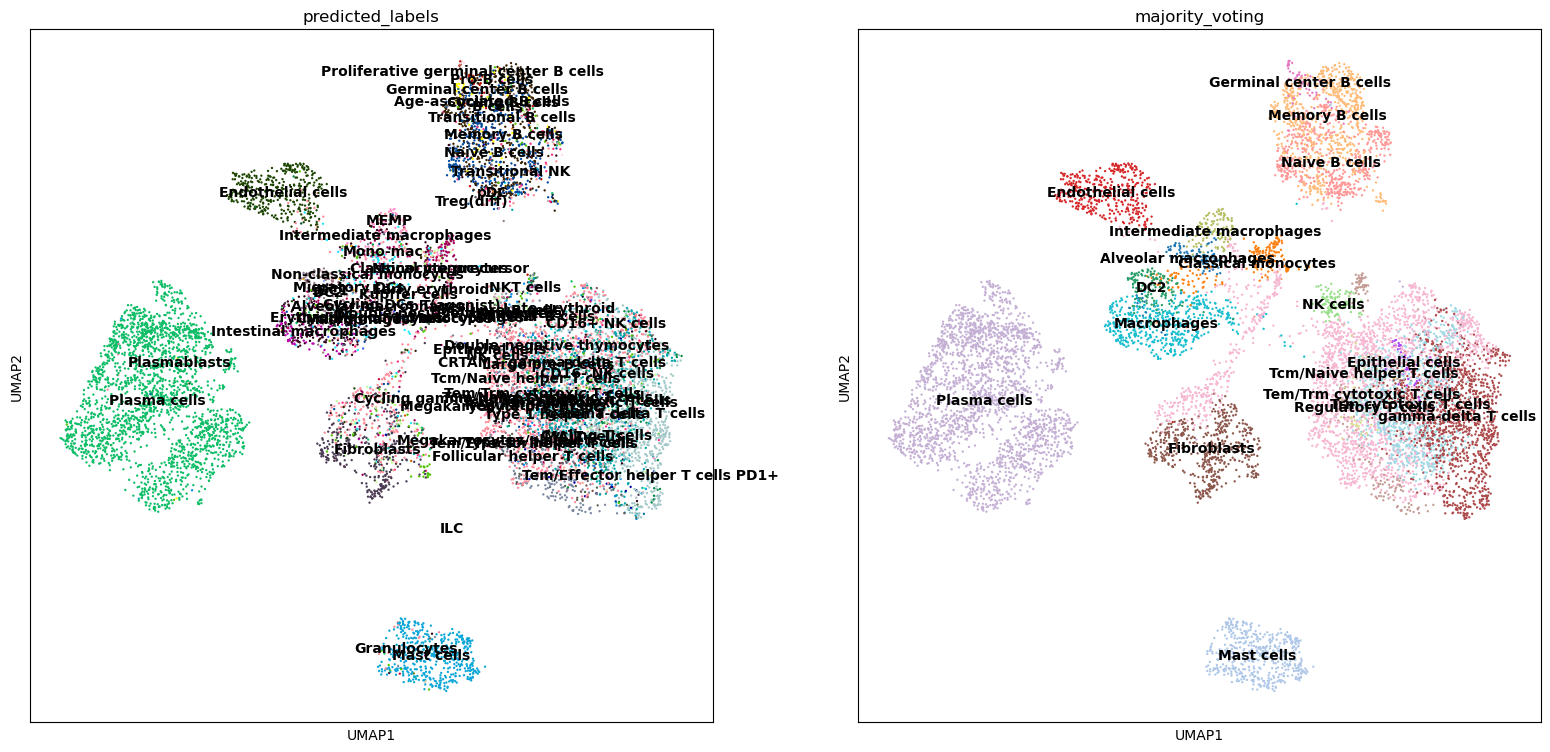

In [21]:
plt.rcParams['figure.figsize'] = (9, 9)
sc.pl.umap(adata, color = ["predicted_labels", "majority_voting"],legend_loc='on data')



## 6. Filter for Tregs

In [22]:
# Filter out T cells
adata_tcells = adata[adata.obs["majority_voting"]== "Regulatory T cells"]

In [23]:
adata_tcells

View of AnnData object with n_obs × n_vars = 190 × 30234
    obs: 'HTAN Parent Data File ID', 'HTAN Specimen ID', 'Cell_Type', 'Tumor_Type', 'Sample_Classification', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mito_frac', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'over_clustering', 'predicted_labels_colors', 'majority_voting_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

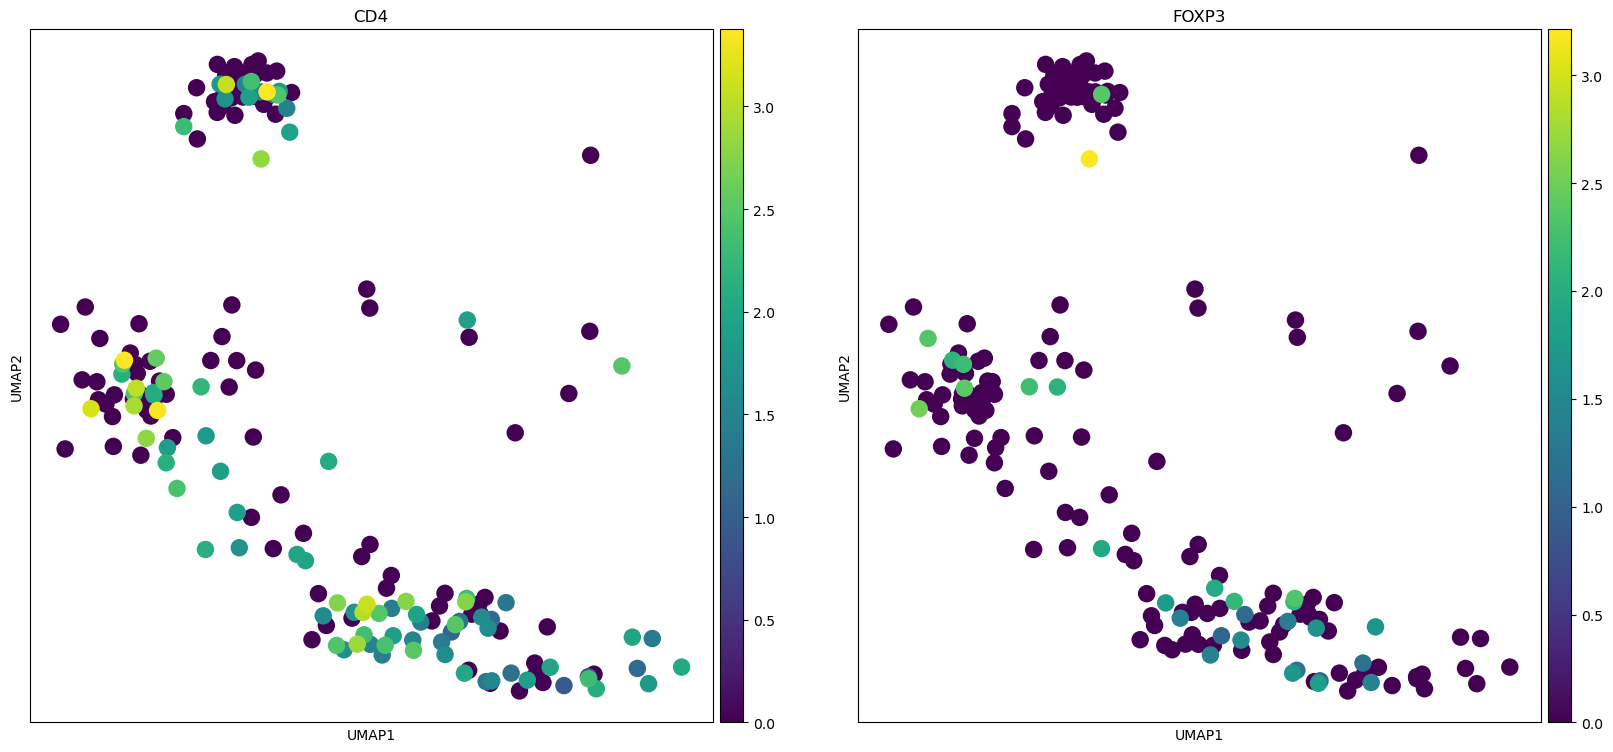

In [24]:
sc.pl.umap(adata_tcells, color = ["CD4", "FOXP3"], cmap='viridis')


In [ ]:
adata_tcells.write(out_tregs_path)